In [1]:
from fastai.vision.all import *
from fastai import *
from torch import nn, optim
import torch

from IPython.display import display, YouTubeVideo


In [2]:
SIZE = {'width':1000, 'height': 600}


In [3]:
path = untar_data(URLs.PETS)


In [4]:
list(path.ls())


[Path('/home/kyle/.fastai/data/oxford-iiit-pet/images'),
 Path('/home/kyle/.fastai/data/oxford-iiit-pet/annotations')]

In [5]:
!tree {str(path/'images')} | grep .jpg | shuf -n 10


├── Bombay_111.jpg
├── newfoundland_198.jpg
├── Siamese_176.jpg
├── great_pyrenees_63.jpg
├── beagle_8.jpg
├── japanese_chin_55.jpg
├── newfoundland_177.jpg
├── english_setter_108.jpg
├── British_Shorthair_106.jpg
├── Sphynx_20.jpg


In [6]:
def label_func(filename):
    return '_'.join(filename.split('_')[:-1])


In [7]:
dls = ImageDataLoaders.from_name_func(
    path=path,
    fnames=get_image_files(path/'images'),
    label_func=label_func,
    valid_pct=0.2,
    item_tfms=Resize(224),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
)


/home/kyle/yes/envs/cn_ml_course/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
imagenet_stats


([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

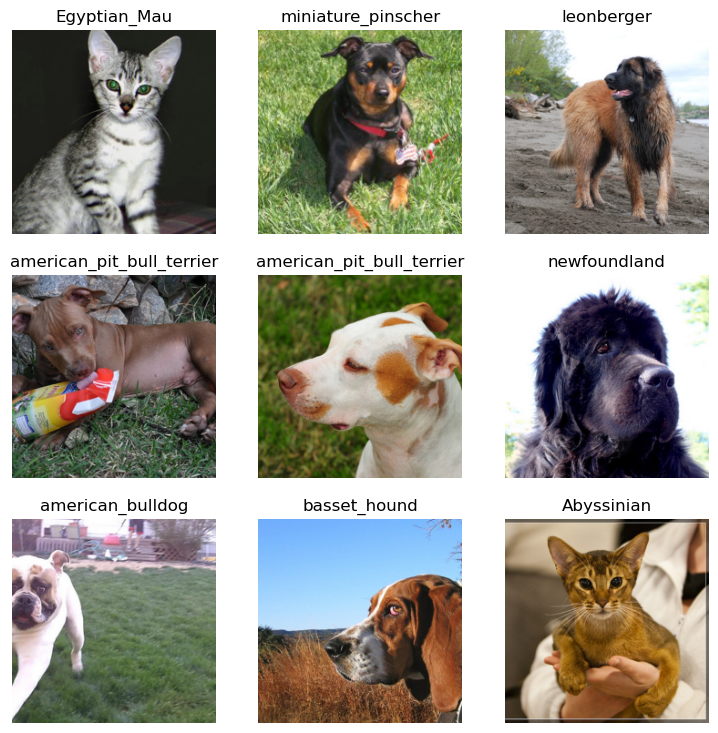

In [9]:
dls.show_batch()


In [10]:
cbs = [
    EarlyStoppingCallback(patience=3)
]

learn = cnn_learner( # Instantiate a learner object
    dls, # Pass the dataloaders
    models.resnet34, # Specify the architechture you want to use
    pretrained=False, # Tell it NOT to fetch the ImageNet weights
    cbs=cbs, # Pass the callbacks
    metrics=[accuracy, error_rate] # Pass the metrics you want to see
)


/home/kyle/yes/envs/cn_ml_course/lib/python3.12/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [ ]:
print(f"""
There are {learn.dls.c} categories.
If we guessed randomly, we would have about a {100. * 1/learn.dls.c:.02f}% chance of guessing correctly.
""")



There are 37 categories.
If we guessed randomly, we would have about a 2.70% chance of guessing correctly.



In [12]:
learn.fit_one_cycle(5, 1e-3)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.644462,5.599286,0.046008,0.953992,04:27
1,4.146400,3.532068,0.100135,0.899865,04:22
2,3.905778,3.839895,0.105548,0.894452,04:19
3,3.636549,3.080225,0.175237,0.824763,04:24
4,3.362396,2.992261,0.189445,0.810555,04:27


In [13]:
cbs = [
    EarlyStoppingCallback(patience=3)
]

learn = cnn_learner( # Instantiate a learner object
    dls, # Pass the dataloaders
    models.resnet34, # Specify the architecture you want to use
    pretrained=True, # Tell it to fetch the ImageNet weights
    cbs=cbs, # Pass the callbacks
    metrics=[accuracy, error_rate] # Pass the metrics you want to see
)


In [14]:
learn.model[1]


Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

In [15]:
LR = 1e-3


In [16]:
# Train the classifier head
learn.fit_one_cycle(1, LR)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.199728,0.332115,0.896482,0.103518,03:08


In [17]:
# Unfreeze the backbone
learn.unfreeze()


In [20]:
import gradio as gr


TensorCategory(2)


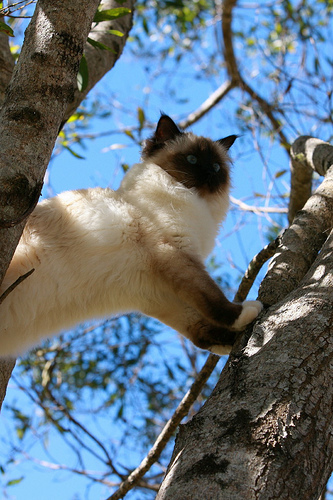

In [21]:
# grab one image from our training dataset
img, cat = dls.train_ds[0]
print(cat)
img


In [ ]:
breed, cat_id, logits = learn.predict(img)
print(breed, cat_id, sep='\n')
print(logits.sum())


Siamese
tensor(10)
tensor(1.0000)


In [23]:
def recognize_pet(img):
    breed, cat_id, logits = learn.predict(img)
    proba = float(logits.softmax(dim=0).max())
    return f"""
    Breed: {breed},
    Probability: {proba:.04f}
    """

print(recognize_pet(img))



    Breed: Siamese,
    Probability: 0.0501
    


In [25]:
gr.Interface(recognize_pet, inputs=gr.Image(type="filepath"), outputs=gr.Label()).launch(inline=True, share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://2fc0c77a078276cdd4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv
